In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re, glob, os, json, math
import pandas as pd, numpy as np

BASE = '/content/drive/MyDrive/.ipynb_checkpoints'
CLIENT_DIR  = f'{BASE}/datasets_client'
SERVER_DIR  = f'{BASE}/datasets_server'
CARBON_DIR  = f'{BASE}/host_power_carbon'

HOST_PER_SEC   = 8.3 / 3600        # $/s (g4dn.metal eu-north-1)
PRICE_EGR_KB = 0.09 / (1024*1024)  # $ per kbit

SLICE_PER_HOST  = {                 # number of vGPU slices per host
    8: 16,      # T4-8Q (8 GB)
    4: 32,      # T4-4Q (4 GB)
}

EGR_FREE_GB       = 100             # free tier / month
EGR_PRICE_USD_GB  = 0.09
monthly_egr_gb = 0.00


In [ ]:
import fnmatch, os, glob, json, math


def parse_name(fname:str):
    """Return (case, net, vram, rep). Accept both naming patterns."""
    b = os.path.basename(fname).lower()
    m = re.match(r'(\w+?)_(clean|impair)_(\d+)gb.*?rep[_ ]?(\d)', b)
    if not m:
        raise ValueError('name pattern fail → ' + b)
    case, net, vram, rep = m.groups()
    return case, net, int(vram), int(rep)

def carbon_g(case, net, vram, rep):
    """Return carbon_g from JSON (case-insensitive match)."""
    base = f'{case}_{net}_{vram}'
    patterns = [
        f'{base}gb*_rep{rep}_*_carbon.json',   # 8gb
        f'{base}GB*_rep{rep}_*_carbon.json',   # 8GB
        f'{case}_{net}_{vram}gb_vram*_rep_{rep}_*_carbon.json',
        f'{case}_{net}_{vram}GB_vram*_rep_{rep}_*_carbon.json',
    ]
    for pat in patterns:
        for fname in os.listdir(CARBON_DIR):
            if fnmatch.fnmatch(fname, pat):
                with open(os.path.join(CARBON_DIR, fname)) as f:
                    return json.load(f)['carbon_g']
    print('⚠ carbon JSON missing:', base, 'rep', rep)
    return math.nan

def clean_fdt(col):
    """drop NaN / >1000 ms values; keep rest."""
    s = pd.to_numeric(col, errors='coerce')
    return s[(s.notna()) & (s < 1000)]

p0 = 4.398909
p1 = -0.006793     # RTT term
p2 = -0.117927     # PL term
p3 = 85e-6         # RTT^2 * RJ
p4 = -0.006595     # RTT * RJ^2
p5 = 817e-6        # RTT * RJ^3

def mos_poly_reg(rtt_ms: float, pl_pct: float, rj_ms: float) -> float:
    x = (p0 + p1*rtt_ms + p2*pl_pct +
         p3*(rtt_ms**2)*rj_ms +
         p4*rtt_ms*(rj_ms**2) +
         p5*rtt_ms*(rj_ms**3))
    return max(1.0, min(5.0, x))      # clamp to [1,5]



In [ ]:
rows = []

def find_col(df, *keywords):
    """
    Return first column whose lowercase header contains *all* keywords.
    Raises KeyError if none found.
    """
    kws = [k.lower() for k in keywords]
    for col in df.columns:
        lc = col.lower()
        if all(k in lc for k in kws):
            return col
    raise KeyError('missing column with: ' + ','.join(kws))

for qpath in glob.glob(f'{CLIENT_DIR}/*.csv'):
    try:
        case, net, vram, rep = parse_name(qpath)
    except ValueError:
        continue

    df = pd.read_csv(qpath)

    # ---------- Frame-delivery column ----------
    fdt_col = next((c for c in df.columns
                    if 'frame' in c.lower() and 'delivery' in c.lower()), None)
    if not fdt_col:
        print('⚠ No FDT col →', qpath)
        continue

    fdt = clean_fdt(df[fdt_col])
    L95 = np.percentile(fdt, 95) if not fdt.empty else 0.0

    # ---------- RTT, Jitter, Packet-loss ----------
    try:
        rtt_col    = find_col(df, 'round', 'trip')
        jitter_col = find_col(df, 'jitter')
    except KeyError as e:
        print('⚠', e, '→', qpath)
        continue

    # RTT (ms) – strip blanks, coerce non-numeric to NaN, then mean
    rtt_ms = (
        pd.to_numeric(df[rtt_col].astype(str).str.strip(), errors='coerce')
        .mean(skipna=True)
    )

    # jitter column is micro-seconds → convert to ms
    jitter_ms = (
        pd.to_numeric(df[jitter_col], errors='coerce')
        .std(skipna=True) / 1000.0
    )

    # Packet-loss %
    lost = df['Packets Lost (cumulative)'].iloc[-1]
    drop = df['Packets Dropped (cumulative)'].iloc[-1]
    recv = df['Packets Received (total)'].iloc[-1]
    pl_pct = 100.0 * (lost + drop) / max(1, recv)

    mos = mos_poly_reg(rtt_ms, pl_pct, jitter_ms)
    Q   = 5.0 - mos        # 0 = perfect, 4 = worst

    sec = len(df)

    slices = SLICE_PER_HOST[vram]
    C_vm   = sec * HOST_PER_SEC / slices

    # Egress in GB
    kbits_total = df['Bandwidth Utilization (kbps)'].astype(float).sum()
    GB_out      = kbits_total / (8 * 1024 * 1024)   # kbit → GB

    free_left   = max(0.0, EGR_FREE_GB - monthly_egr_gb)
    billable_gb = max(0.0, GB_out - free_left)
    C_egr       = billable_gb * EGR_PRICE_USD_GB


    monthly_egr_gb += GB_out           # update monthly tally

    C = C_vm + C_egr

    # ➊  hourly equivalent
    C_hour  = C * 3600.0 / sec      # or simply HOST_HOURLY_USD / slices

    # ---------- Carbon ----------
    E = carbon_g(case, net, vram, rep)

    rows.append(dict(case=case, net=net, vram=vram, rep=rep,
                    C=C, C_hour=C_hour, Q=Q, E=E, L95=L95))

# ---------- Save results ----------
results = pd.DataFrame(rows).sort_values(['case', 'net', 'vram', 'rep'])
out = f'{BASE}/results_raw.csv'
results.to_csv(out, index=False)
print(f'✅  {len(results)} rows written →', out)
results


✅  14 rows written → /content/drive/MyDrive/.ipynb_checkpoints/results_raw.csv


,case,net,vram,rep,C,C_hour,Q,E,L95
5,idle,clean,4,1,0.049065,0.259375,0.000000,0.24,28.100
4,idle,clean,4,2,0.049209,0.259375,0.000000,0.24,28.150
0,idle,clean,8,1,0.103606,0.518750,0.614845,0.25,28.100
3,idle,clean,8,2,0.112396,0.518750,0.615127,0.25,28.100
1,map,clean,4,1,0.064339,0.259375,0.619457,0.23,26.640
9,map,clean,8,1,0.108938,0.518750,0.619336,0.25,25.625
8,map,clean,8,2,0.104470,0.518750,0.618645,0.25,24.460
12,map,impair,4,1,0.002954,0.259375,1.198124,0.25,112.700
10,map,impair,8,1,0.102453,0.518750,1.199615,0.25,83.750
2,soc,clean,4,1,0.054973,0.259375,0.621223,0.24,37.180


In [ ]:
print(results.columns.tolist())


['case', 'net', 'vram', 'rep', 'C', 'C_hour', 'Q', 'E', 'L95']


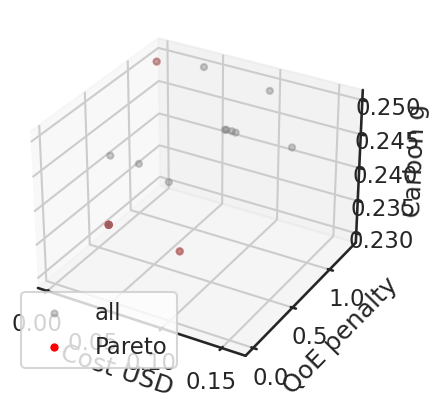

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')
ax.scatter(results.C, results.Q, results.E, c='grey', alpha=.4, label='all')
ax.scatter(frontier.C, frontier.Q, frontier.E, c='r', label='Pareto')
ax.set_xlabel('Cost USD'); ax.set_ylabel('QoE penalty'); ax.set_zlabel('Carbon g')
ax.legend(); plt.show()


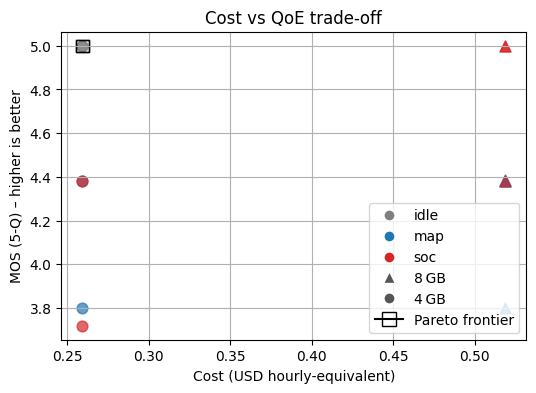

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# ---------- compute MOS = 5 - Q for clarity ------------------------------
results["MOS"] = 5.0 - results["Q"]          # higher = better

# ---------- scatter: Cost vs QoE (MOS) ------------------------------------
fig, ax = plt.subplots(figsize=(6,4))

colors = {'idle':'#808080', 'map':'#1f77b4', 'soc':'#d62728'}
markers = {4:'o', 8:'^'}

for _, r in results.iterrows():
    ax.scatter(r.C_hour, r.MOS,
               color=colors.get(r.case, '#444444'),
               marker=markers.get(r.vram, 'o'),
               s=60, alpha=0.7)

# highlight Pareto-efficient points
from scipy.spatial import ConvexHull
import numpy as np

def pareto(df, cols=('C_hour','Q')):
    pts = df[list(cols)].to_numpy()
    eff = np.ones(len(pts), bool)
    for i,p in enumerate(pts):
        eff[i] = ~np.any((pts <= p).all(axis=1) & (pts < p).any(axis=1))
    return df.loc[eff]

front = pareto(results, ('C_hour','Q'))
ax.scatter(front.C_hour, 5-front.Q, facecolors='none', edgecolors='k',
           marker='s', s=80, label='Pareto')

# aesthetics
ax.set_xlabel("Cost (USD hourly‑equivalent)")
ax.set_ylabel("MOS (5‑Q) – higher is better")
ax.set_title("Cost vs QoE trade‑off")
ax.grid(True)

# custom legend
from matplotlib.lines import Line2D
legend_elems = [Line2D([0],[0], marker='o', color='w', label='idle', markerfacecolor=colors['idle'], markersize=8),
                Line2D([0],[0], marker='o', color='w', label='map',  markerfacecolor=colors['map'],  markersize=8),
                Line2D([0],[0], marker='o', color='w', label='soc',  markerfacecolor=colors['soc'],  markersize=8),
                Line2D([0],[0], marker='^', color='w', label='8 GB', markerfacecolor='#555555', markersize=8),
                Line2D([0],[0], marker='o', color='w', label='4 GB', markerfacecolor='#555555', markersize=8),
                Line2D([0],[0], marker='s', color='k', label='Pareto frontier', markerfacecolor='none', markersize=10)]
ax.legend(handles=legend_elems, loc='lower right')

plt.show()


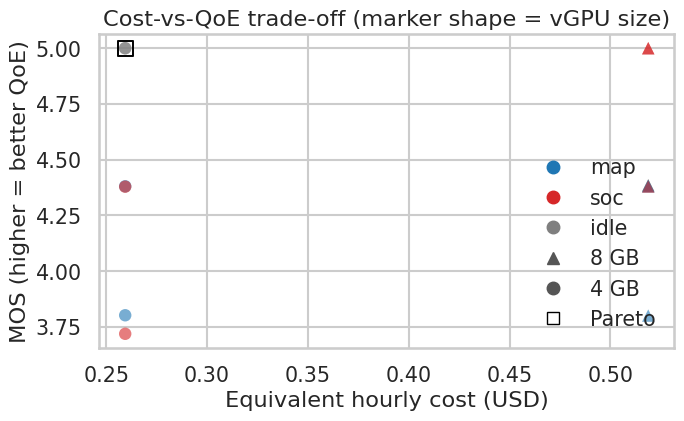

In [ ]:


# derive MOS for clarity
results["MOS"] = 5.0 - results["Q"]

##############################################################################
# 2.  Pareto-front helper  (2-D: Cost_hour ↓  ,  Q ↓)                       #
##############################################################################
def pareto_2d(df, x="C_hour", y="Q"):
    pts = df[[x, y]].to_numpy()
    eff = np.ones(len(pts), bool)
    for i, p in enumerate(pts):
        eff[i] = ~np.any((pts <= p).all(axis=1) &
                         (pts < p).any(axis=1))
    return df[eff]

front = pareto_2d(results, "C_hour", "Q")

import seaborn as sns
sns.set_context("talk", font_scale=0.9)
sns.set_style("whitegrid")

palette = dict(idle="#7f7f7f", map="#1f77b4", soc="#d62728")
markers = {4: "o", 8: "^"}


fig, ax = plt.subplots(figsize=(7, 4.5))

for (_, r) in results.iterrows():
    ax.scatter(r.C_hour, r.MOS,
               c=palette.get(r.case, "#444"),
               marker=markers.get(r.vram, "o"),
               s=80, alpha=0.6,
               edgecolors="none")

# Pareto points (open squares)
ax.scatter(front.C_hour, front.MOS,
           facecolors="none", edgecolors="black",
           marker="s", s=120, linewidths=1.2,
           label="Pareto-efficient")

# annotate three policy-relevant configs
labels = {
    ("map", "clean", 4): "map clean 4 GB",
    ("map", "impair", 4): "map impair 4 GB",
    ("soc", "clean", 8): "soc clean 8 GB",
}
for (cse, net, vram), text in labels.items():
    row = front.query("case==@cse & net==@net & vram==@vram")
    if not row.empty:
        x, y = row.iloc[0][["C_hour", "MOS"]]
        ax.annotate(text, (x, y),
                    xytext=(4, 4),
                    textcoords="offset points",
                    fontsize=9,
                    bbox=dict(boxstyle="round,pad=.2",
                              fc="white", alpha=.8),
                    arrowprops=dict(arrowstyle="-", lw=.5))

# axes & legend
ax.set_xlabel("Equivalent hourly cost (USD)")
ax.set_ylabel("MOS (higher = better QoE)")
ax.set_title("Cost-vs-QoE trade-off (marker shape = vGPU size)")
legend_elems = [plt.Line2D([0], [0], marker="o", ls="", label="map", c=palette["map"]),
                plt.Line2D([0], [0], marker="o", ls="", label="soc", c=palette["soc"]),
                plt.Line2D([0], [0], marker="o", ls="", label="idle",c=palette["idle"]),
                plt.Line2D([0], [0], marker="^", ls="", label="8 GB", c="#555"),
                plt.Line2D([0], [0], marker="o", ls="", label="4 GB", c="#555"),
                plt.Line2D([0], [0], marker="s", ls="", label="Pareto", c="w",
                           markeredgecolor="k")]
ax.legend(handles=legend_elems, frameon=False, loc="lower right")

plt.tight_layout()
plt.show()


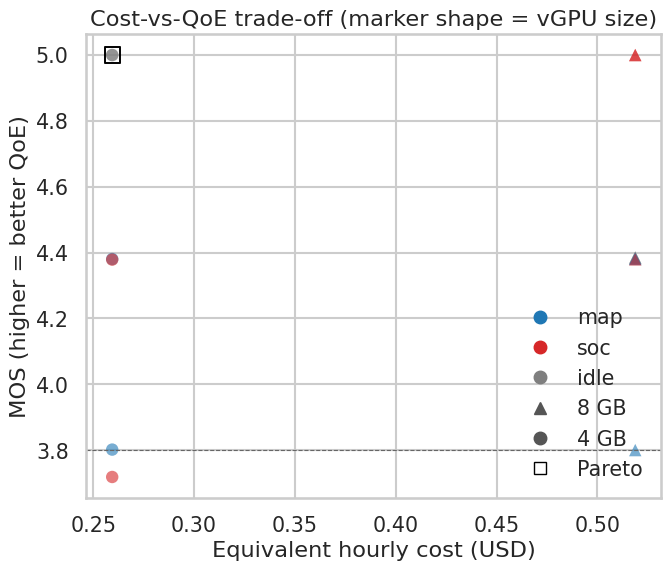

In [ ]:


# derive MOS for clarity
results["MOS"] = 5.0 - results["Q"]
offset = {'map':-0.004, 'soc':+0.004}
results['C_plot'] = results['C_hour'] + results['case'].map(offset)


##############################################################################
# 2.  Pareto-front helper  (2-D: Cost_hour ↓  ,  Q ↓)                       #
##############################################################################
def pareto_2d(df, x="C_hour", y="Q"):
    pts = df[[x, y]].to_numpy()
    eff = np.ones(len(pts), bool)
    for i, p in enumerate(pts):
        eff[i] = ~np.any((pts <= p).all(axis=1) &
                         (pts < p).any(axis=1))
    return df[eff]

front = pareto_2d(results, "C_hour", "Q")

##############################################################################
# 3.  Styling palettes                                                      #
##############################################################################
import seaborn as sns
sns.set_context("talk", font_scale=0.9)
sns.set_style("whitegrid")

palette = dict(idle="#7f7f7f", map="#1f77b4", soc="#d62728")
markers = {4: "o", 8: "^"}

##############################################################################
# 4.  Figure                                                                 #
##############################################################################
fig, ax = plt.subplots(figsize=(7, 6))

# all runs
for (_, r) in results.iterrows():
    ax.scatter(r.C_hour, r.MOS,
               c=palette.get(r.case, "#444"),
               marker=markers.get(r.vram, "o"),
               s=80, alpha=0.6,
               edgecolors="none")

# Pareto points (open squares)
ax.scatter(front.C_hour, front.MOS,
           facecolors="none", edgecolors="black",
           marker="s", s=120, linewidths=1.2,
           label="Pareto-efficient")

# annotate three policy-relevant configs
labels = {
    ("map", "clean", 4): "map clean 4 GB",
    ("map", "impair", 4): "map impair 4 GB",
    ("soc", "clean", 8): "soc clean 8 GB",
}
for (cse, net, vram), text in labels.items():
    row = front.query("case==@cse & net==@net & vram==@vram")
    if not row.empty:
        x, y = row.iloc[0][["C_hour", "MOS"]]
        ax.annotate(text, (x, y),
                    xytext=(4, 4),
                    textcoords="offset points",
                    fontsize=9,
                    bbox=dict(boxstyle="round,pad=.2",
                              fc="white", alpha=.8),
                    arrowprops=dict(arrowstyle="-", lw=.5))


# axes & legend
ax.set_xlabel("Equivalent hourly cost (USD)")
ax.set_ylabel("MOS (higher = better QoE)")
ax.axhline(3.8, ls="--", lw=0.8, color="#666", label="MOS = 3.8 threshold")

ax.set_title("Cost-vs-QoE trade-off (marker shape = vGPU size)")
legend_elems = [plt.Line2D([0], [0], marker="o", ls="", label="map", c=palette["map"]),
                plt.Line2D([0], [0], marker="o", ls="", label="soc", c=palette["soc"]),
                plt.Line2D([0], [0], marker="o", ls="", label="idle",c=palette["idle"]),
                plt.Line2D([0], [0], marker="^", ls="", label="8 GB", c="#555"),
                plt.Line2D([0], [0], marker="o", ls="", label="4 GB", c="#555"),
                plt.Line2D([0], [0], marker="s", ls="", label="Pareto", c="w",
                           markeredgecolor="k")]
ax.legend(handles=legend_elems, frameon=False, loc="lower right")

plt.tight_layout()
plt.show()


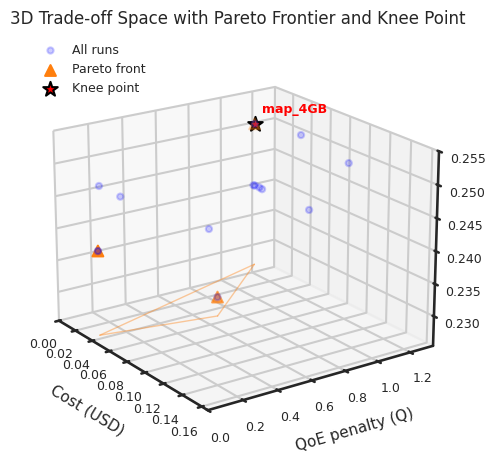

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from scipy.spatial import ConvexHull
import numpy as np
import pandas as pd

csv_path = "/content/drive/MyDrive/.ipynb_checkpoints/results_raw.csv"
results = pd.read_csv(csv_path)

def pareto_frontier(df, cols=('C', 'Q', 'E')):
    pts = df[list(cols)].to_numpy()
    is_eff = np.ones(len(pts), dtype=bool)
    for i, p in enumerate(pts):
        is_eff[i] = not np.any((pts <= p).all(axis=1) & (pts < p).any(axis=1))
    return df.loc[is_eff]

# Compute Pareto and knee:
frontier = pareto_frontier(results, ('C','Q','E'))

# Normalize frontier for knee‐point detection:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
norm_vals = scaler.fit_transform(frontier[['C','Q','E']])
dists = np.linalg.norm(norm_vals, axis=1)
knee_idx = np.argmax(dists)
knee_point = frontier.iloc[knee_idx]

mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.serif']        = ['Times New Roman', 'Times', 'serif']
mpl.rcParams['text.usetex']       = False   # or True if you have a TeX engine installed
mpl.rcParams['axes.titlesize']    = 12
mpl.rcParams['axes.labelsize']    = 11
mpl.rcParams['xtick.labelsize']   = 9
mpl.rcParams['ytick.labelsize']   = 9
mpl.rcParams['legend.fontsize']   = 9
mpl.rcParams['figure.titlesize']  = 13

fig = plt.figure(figsize=(7.5, 5))
ax  = fig.add_subplot(111, projection='3d')

ax.scatter(
    results["C"], results["Q"], results["E"],
    color='blue', alpha=0.2, s=20, label="All runs"
)

ax.scatter(
    frontier["C"], frontier["Q"], frontier["E"],
    color='tab:orange', marker='^', s=60, label="Pareto front"
)

try:
    hull2d = ConvexHull(frontier[['C','Q']])
    for simplex in hull2d.simplices:
        x_line = frontier.iloc[simplex][['C','Q']].values.T
        z_base = np.full(2, frontier["E"].min() - 0.003)
        ax.plot(x_line[0], x_line[1], z_base, color='tab:orange', alpha=0.4, linewidth=1)
except Exception:
    pass

ax.scatter(
    knee_point["C"], knee_point["Q"], knee_point["E"],
    color='red', marker='*', s=120, edgecolor='black', label="Knee point"
)
ax.text(
    knee_point["C"] + 0.005,  # slight offset in each axis to avoid overlap
    knee_point["Q"] + 0.02,
    knee_point["E"] + 0.002,
    f"{knee_point['case']}_{int(knee_point['vram'])}GB",
    color='red', fontsize=9, fontweight='bold'
)

ax.set_xlabel("Cost (USD)",   labelpad=8)
ax.set_ylabel("QoE penalty (Q)", labelpad=8)
ax.set_zlabel("Carbon (gCO$_2$)", labelpad=8)

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.zaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

ax.set_xlim(0, results["C"].max() * 1.05)
ax.set_ylim(0, results["Q"].max() * 1.05)
ax.set_zlim(results["E"].min() * 0.98, results["E"].max() * 1.02)

ax.view_init(elev=20, azim=-35)

ax.set_title("3D Trade‐off Space with Pareto Frontier and Knee Point")
ax.legend(loc='upper left', frameon=False)

ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
fig.tight_layout()

fig.savefig("pareto_knee_ifac.pdf", dpi=300)   # vector PDF recommended
fig.savefig("pareto_knee_ifac.png", dpi=300)   # also save a PNG at 300 dpi

plt.show()
